In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
from transformers import AutoModelForMaskedLM

from transformers import AutoTokenizer, AutoModel
import re

tokenizer1 = AutoTokenizer.from_pretrained("jhu-clsp/bernice", model_max_length=128)
tokenizer2 = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")
tokenizer3 = AutoTokenizer.from_pretrained("google/muril-base-cased")

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import random
seed_val=3407
torch.manual_seed(seed_val)
np.random.seed(seed_val)
random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Load whole datasets
df_train = pd.read_csv("/kaggle/input/ipo-wholedataset/IPO_WholeDataset_ClassCreate.csv", names = ["tweet", "classes"])

In [ ]:
df_train = df_train.iloc[1: , :]
df_train.head()

,tweet,classes
1,Millions of Indians investing in the country’s...,0.0
2,టోకు ద్రవ్యోల్బణమే కీలకం via తాజా వార్తలు | ...,1.0
3,મેરે રે કો એસે ધક ધક હો રહા હે....\nfingers cr...,1.0
4,The country's largest insurer will list itself...,1.0
5,Can a full time employee ask for board of dire...,1.0


In [ ]:
df_train.describe()

,tweet,classes
count,960,960
unique,944,3
top,Kaun kaun god se prey kar rahe ki unko LICIPO ...,1.0
freq,3,657


In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-08

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        #self.targets = self.data.class
        # using loop
        #y=list(df_train['class'])
        y=list(dataframe.classes)
        res = [eval(i) for i in y]
        print("Modified list is: ", res)
        yInt = [int(res) for res in res]
        print("final->",yInt)
        self.targets = yInt
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
            #'targets': torch.tensor(self.targets[index], dtype=torch.str)
        }

In [ ]:
train_size = 0.6
#train_data=df_train.sample(frac=train_size,random_state=200)
train_data=df_train.sample(frac=train_size,random_state=seed_val)
test_data=df_train.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set1 = SentimentData(train_data, tokenizer1, MAX_LEN)
testing_set1 = SentimentData(test_data, tokenizer1, MAX_LEN)

training_set2 = SentimentData(train_data, tokenizer2, MAX_LEN)
testing_set2 = SentimentData(test_data, tokenizer2, MAX_LEN)

training_set3 = SentimentData(train_data, tokenizer3, MAX_LEN)
testing_set3 = SentimentData(test_data, tokenizer3, MAX_LEN)

FULL Dataset: (960, 2)
TRAIN Dataset: (576, 2)
TEST Dataset: (384, 2)
Modified list is:  [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader1 = DataLoader(training_set1, **train_params)
testing_loader1 = DataLoader(testing_set1, **test_params)

training_loader2 = DataLoader(training_set2, **train_params)
testing_loader2 = DataLoader(testing_set2, **test_params)

training_loader3 = DataLoader(training_set3, **train_params)
testing_loader3 = DataLoader(testing_set3, **test_params)

In [ ]:
weights = [.762, .316, .923]
class_weights=torch.tensor(weights,dtype=torch.float)
loss_function = torch.nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
class BerniceClass(torch.nn.Module):
    def __init__(self):
        super(BerniceClass, self).__init__()
        self.l1 = AutoModelForMaskedLM.from_pretrained("jhu-clsp/bernice")
        #self.pre_classifier = torch.nn.Linear(768, 768)
        #self.pre_classifier = torch.nn.Linear(768, 68)
        self.pre_classifier = torch.nn.Linear(250000, 68)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(68, 3)
        self.loss_fn = loss_function

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
class TwhinClass(torch.nn.Module):
    def __init__(self):
        super(TwhinClass, self).__init__()
        self.l1 = AutoModelForMaskedLM.from_pretrained("Twitter/twhin-bert-base")
        self.pre_classifier = torch.nn.Linear(250002, 68)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(68, 3)
        self.loss_fn = loss_function

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
class MURILClass(torch.nn.Module):
    def __init__(self):
        super(MURILClass, self).__init__()
        #self.l1 = AutoModel.from_pretrained("ai4bharat/indic-bert")
        self.l1 = AutoModelForMaskedLM.from_pretrained("google/muril-base-cased")
        #self.pre_classifier = torch.nn.Linear(768, 768)
        self.pre_classifier = torch.nn.Linear(197285, 68)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(68, 3)
        self.loss_fn=loss_function

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model1 = BerniceClass()
model1.to(device)

model2 = TwhinClass()
model2.to(device)

model3 = MURILClass()
model3.to(device)


Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MURILClass(
  (l1): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(197285, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                

In [ ]:
# Creating optimizer
optimizer1 = torch.optim.SGD(params =  model1.parameters(), lr=LEARNING_RATE)
optimizer2 = torch.optim.SGD(params =  model2.parameters(), lr=LEARNING_RATE)
optimizer3 = torch.optim.SGD(params =  model3.parameters(), lr=LEARNING_RATE)

In [ ]:
print("Load the predictions of Model 4")
data = pd.read_csv('/kaggle/input/setting4-txt-output-m4-m5/final_prediction4_S2_U.txt', sep=",", header = None)
#print(data)

Load the predictions of Model 4


In [ ]:
print("Load the predictions of Model 5")
data1 = pd.read_csv('/kaggle/input/setting4-txt-output-m4-m5/final_prediction5_S2_U.txt', sep=",", header = None)
#print(data1)

Load the predictions of Model 5


In [ ]:
# For Model 1, pair 1 to be updated
predicted11 = []
original11=[]
# For Model 2, pair 1 to be updated
predicted12 = []
original12=[]
# For Model 3, pair 1 to be updated
predicted13 = []
original13=[]

def calcuate_accuracy(preds, targets, number):
    if number==1:
        predicted11.append(preds.tolist())
        original11.append(targets.tolist())
        n_correct1 = (preds==targets).sum().item()
        return n_correct1
    if number==2:
        predicted12.append(preds.tolist())
        original12.append(targets.tolist())
        n_correct2 = (preds==targets).sum().item()
        return n_correct2
    if number==3:
        predicted13.append(preds.tolist())
        original13.append(targets.tolist())
        n_correct3 = (preds==targets).sum().item()
        return n_correct3

In [ ]:
def calcuate_accuracyTrain(preds, targets):
    n_correct = (preds==targets).sum().item()
    #print("Inside accuracyTrain() method")
    return n_correct

In [ ]:
def train(model, optimizer, training_loader, epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracyTrain(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            #print(f"Training Loss per 5000 steps: {loss_step}")
            #print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
EPOCHS = 4
print(f"Finetuning with FIRST model:::")
for epoch in range(EPOCHS):
    train(model1, optimizer1, training_loader1, epoch)
print(f"Finetuning with SECOND model:::")
for epoch in range(EPOCHS):
    train(model2, optimizer2, training_loader2, epoch)    
print(f"Finetuning with THIRD model:::")
for epoch in range(EPOCHS):
    train(model3, optimizer3, training_loader3, epoch) 

Finetuning with FIRST model:::


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
72it [00:39,  1.84it/s]


The Total Accuracy for Epoch 0: 42.013888888888886
Training Loss Epoch: 1.120372787117958
Training Accuracy Epoch: 42.013888888888886


72it [00:37,  1.94it/s]


The Total Accuracy for Epoch 1: 41.84027777777778
Training Loss Epoch: 1.1341885411077075
Training Accuracy Epoch: 41.84027777777778


72it [00:37,  1.94it/s]


The Total Accuracy for Epoch 2: 39.93055555555556
Training Loss Epoch: 1.1557869985699654
Training Accuracy Epoch: 39.93055555555556


72it [00:37,  1.94it/s]


The Total Accuracy for Epoch 3: 42.88194444444444
Training Loss Epoch: 1.135161096851031
Training Accuracy Epoch: 42.88194444444444
Finetuning with SECOND model:::


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
72it [00:39,  1.84it/s]


The Total Accuracy for Epoch 0: 40.625
Training Loss Epoch: 1.3135435448752508
Training Accuracy Epoch: 40.625


72it [00:38,  1.85it/s]


The Total Accuracy for Epoch 1: 44.791666666666664
Training Loss Epoch: 1.3088146621982257
Training Accuracy Epoch: 44.791666666666664


72it [00:38,  1.85it/s]


The Total Accuracy for Epoch 2: 46.875
Training Loss Epoch: 1.2793087139725685
Training Accuracy Epoch: 46.875


72it [00:38,  1.85it/s]


The Total Accuracy for Epoch 3: 45.833333333333336
Training Loss Epoch: 1.2705562425156434
Training Accuracy Epoch: 45.833333333333336
Finetuning with THIRD model:::


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
72it [00:32,  2.24it/s]


The Total Accuracy for Epoch 0: 28.47222222222222
Training Loss Epoch: 2.3131380950411162
Training Accuracy Epoch: 28.47222222222222


72it [00:32,  2.22it/s]


The Total Accuracy for Epoch 1: 31.944444444444443
Training Loss Epoch: 1.8088089807165995
Training Accuracy Epoch: 31.944444444444443


72it [00:32,  2.22it/s]


The Total Accuracy for Epoch 2: 38.020833333333336
Training Loss Epoch: 1.635213892492983
Training Accuracy Epoch: 38.020833333333336


72it [00:32,  2.22it/s]

The Total Accuracy for Epoch 3: 38.888888888888886
Training Loss Epoch: 1.5988409428132906
Training Accuracy Epoch: 38.888888888888886


In [ ]:
def valid(model, testing_loader, number):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets, number)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                #print(f"Validation Loss per 100 steps: {loss_step}")
                #print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [ ]:
acc1 = valid(model1, testing_loader1, 1)
print(f"Validation Accuracy FIRST Model::::\n")
print("Accuracy on test data = %0.2f%%" % acc1)
acc2 = valid(model2, testing_loader2, 2)
print(f"Validation Accuracy SECOND Model::::\n")
print("Accuracy on test data = %0.2f%%" % acc2)
acc3 = valid(model3, testing_loader3, 3)
print(f"Validation Accuracy THIRD Model::::\n")
print("Accuracy on test data = %0.2f%%" % acc3)

96it [00:08, 10.75it/s]


Validation Loss Epoch: 1.023318521057566
Validation Accuracy Epoch: 38.28125
Validation Accuracy FIRST Model::::

Accuracy on test data = 38.28%


96it [00:09, 10.23it/s]


Validation Loss Epoch: 1.0578507178773482
Validation Accuracy Epoch: 54.427083333333336
Validation Accuracy SECOND Model::::

Accuracy on test data = 54.43%


96it [00:07, 12.33it/s]

Validation Loss Epoch: 1.1538816777368386
Validation Accuracy Epoch: 49.739583333333336
Validation Accuracy THIRD Model::::

Accuracy on test data = 49.74%


In [ ]:
print(len(predicted11))
print(predicted11)
print("***********************************************")
print(len(predicted12))
print(predicted12)
print("***********************************************")
print(len(predicted13))
print(predicted13)
print("***********************************************")

96
[[0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 1, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 1, 1, 1], [0, 1, 0, 0], [0, 1, 1, 0], [1, 0, 1, 1], [0, 0, 0, 0], [1, 1, 1, 0], [0, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 1], [1, 1, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1, 1, 1, 1], [1, 0, 1, 1], [0, 0, 1, 0], [1, 1, 0, 0], [0, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [1, 1, 0, 0], [0, 0, 0, 1], [0, 1, 1, 1], [1, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0], [1, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 1], [1, 0, 0, 0], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [1, 1, 0, 0], [0, 0, 0, 0], [0

In [ ]:
print(len(original11))
print(original11)
print("**************************************")
print(len(original12))
print(original12)
print("**************************************")
print(len(original13))
print(original13)
print("**************************************")

96
[[0, 1, 2, 1], [1, 0, 2, 0], [1, 0, 1, 1], [0, 1, 1, 1], [1, 1, 1, 2], [1, 1, 1, 0], [1, 1, 1, 0], [2, 0, 1, 0], [2, 0, 1, 0], [0, 1, 1, 0], [1, 1, 1, 0], [0, 0, 1, 1], [1, 1, 0, 1], [1, 1, 0, 1], [0, 0, 1, 1], [1, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 2, 1], [1, 0, 1, 0], [1, 1, 1, 1], [0, 1, 1, 1], [0, 2, 1, 1], [1, 1, 0, 1], [1, 0, 0, 1], [1, 0, 1, 1], [1, 1, 1, 0], [1, 1, 1, 1], [0, 1, 1, 0], [1, 1, 0, 0], [0, 0, 0, 1], [2, 1, 1, 1], [1, 0, 2, 1], [1, 1, 0, 1], [0, 2, 1, 1], [1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [2, 1, 1, 2], [1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 1], [0, 0, 0, 1], [1, 2, 0, 1], [1, 1, 1, 1], [0, 0, 1, 1], [2, 1, 2, 0], [1, 2, 1, 0], [1, 1, 0, 0], [1, 0, 1, 1], [0, 1, 1, 1], [1, 1, 2, 2], [0, 1, 1, 2], [1, 1, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2], [2, 1, 1, 1], [1, 1, 1, 1], [1, 0, 1, 0], [1, 2, 1, 1], [2, 1, 1, 0], [1, 1, 0, 2], [1, 1, 1, 2], [1, 1, 0, 1], [1

In [ ]:
final_prediction1 = []
final_prediction2 = []
final_prediction3 = []
for sublist in predicted11:
    for item in sublist:
        final_prediction1.append(item)
for sublist in predicted12:
    for item in sublist:
        final_prediction2.append(item)
for sublist in predicted13:
    for item in sublist:
        final_prediction3.append(item)

In [ ]:
#Loading result of Model 4
prediction4=data.values.tolist()
final_prediction4 = []
#print(prediction4[0][3])
i=0
limit=384
print(limit)
for x in prediction4[0]:
    if i==0: 
        prediction4[0][i] = 1
        #print(prediction4[0][i])
        final_prediction4.append(prediction4[0][i])
    elif i==limit-1:
        prediction4[0][i] = 1
        #print(prediction4[0][i])
        final_prediction4.append(prediction4[0][i])
    else:
        #print(prediction4[0][i])
        final_prediction4.append(prediction4[0][i])
    i = i+1
    #print(i)
print(final_prediction4)        

384
[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [ ]:
prediction5=data1.values.tolist()
final_prediction5 = []
#print(prediction4[0][3])
i=0
limit=384
print(limit)
for x in prediction5[0]:
    if i==0: 
        prediction5[0][i] = 1
        #print(prediction4[0][i])
        final_prediction5.append(prediction5[0][i])
    elif i==limit-1:
        prediction5[0][i] = 1
        #print(prediction4[0][i])
        final_prediction5.append(prediction5[0][i])
    else:
        #print(prediction4[0][i])
        final_prediction5.append(prediction5[0][i])
    i = i+1
    #print(i)
print(final_prediction5)        

384
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
final_original1 = []
final_original2 = []
final_original3 = []
for sublist in original11:
    for item in sublist:
        final_original1.append(item)
final_original2 = []
for sublist in original12:
    for item in sublist:
        final_original2.append(item)
final_original3 = []
for sublist in original13:
    for item in sublist:
        final_original3.append(item)

In [ ]:
print(len(final_prediction1))
print(final_prediction1)
print("*****************************************")
print(len(final_prediction2))
print(final_prediction2)
print("*****************************************")
print(len(final_prediction3))
print(final_prediction3)
print("*****************************************")
print(len(final_prediction4))
print(final_prediction4)
print("*****************************************")
#final_prediction5=data1.values.tolist()
print(len(final_prediction5))
print(final_prediction5)

384
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,

In [ ]:
print(len(final_original1))
print(final_original1)
print("**************************")
print(len(final_original2))
print(final_original2)
print("**************************")
print(len(final_original3))
print(final_original3)
print("**************************")

384
[0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
import sklearn
print("***********Confusion Matrix by MODEL 1 over Test Set**********************")
mat1 = sklearn.metrics.confusion_matrix(final_original1,final_prediction1)
mat1

***********Confusion Matrix by MODEL 1 over Test Set**********************


array([[ 63,  30,   0],
       [174,  84,   0],
       [ 23,  10,   0]])

In [ ]:
print("***********Confusion Matrix by MODEL 2 over Test Set**********************")
mat2 = sklearn.metrics.confusion_matrix(final_original2,final_prediction2)
mat2

***********Confusion Matrix by MODEL 2 over Test Set**********************


array([[ 16,  77,   0],
       [ 65, 193,   0],
       [  8,  25,   0]])

In [ ]:
print("***********Confusion Matrix by MODEL 3 over Test Set**********************")
mat3 = sklearn.metrics.confusion_matrix(final_original3,final_prediction3)
mat3

***********Confusion Matrix by MODEL 3 over Test Set**********************


array([[ 21,  63,   9],
       [ 73, 166,  19],
       [  8,  21,   4]])

In [ ]:
print("***********Confusion Matrix by MODEL 4 over Test Set**********************")
mat4 = sklearn.metrics.confusion_matrix(final_original3,final_prediction4)
mat4

***********Confusion Matrix by MODEL 4 over Test Set**********************


array([[ 40,  53,   0],
       [ 97, 161,   0],
       [  9,  24,   0]])

In [ ]:
print("***********Confusion Matrix by MODEL 5 over Test Set**********************")
mat5 = sklearn.metrics.confusion_matrix(final_original3,final_prediction5)
mat5

***********Confusion Matrix by MODEL 5 over Test Set**********************


array([[  0,  93,   0],
       [  1, 257,   0],
       [  1,  32,   0]])

In [ ]:
print("***********Accuracy by MODEL 1 over Test Set**********************")
sklearn.metrics.accuracy_score(final_original1,final_prediction1)

***********Accuracy by MODEL 1 over Test Set**********************


0.3828125

In [ ]:
print("***********Accuracy by MODEL 2 over Test Set**********************")
sklearn.metrics.accuracy_score(final_original2,final_prediction2)

***********Accuracy by MODEL 2 over Test Set**********************


0.5442708333333334

In [ ]:
print("***********Accuracy by MODEL 3 over Test Set**********************")
sklearn.metrics.accuracy_score(final_original3,final_prediction3)

***********Accuracy by MODEL 3 over Test Set**********************


0.4973958333333333

In [ ]:
print("***********Accuracy by MODEL 4 over Test Set**********************")
sklearn.metrics.accuracy_score(final_original3,final_prediction4)

***********Accuracy by MODEL 4 over Test Set**********************


0.5234375

In [ ]:
print("***********Accuracy by MODEL 5 over Test Set**********************")
sklearn.metrics.accuracy_score(final_original3,final_prediction5)

***********Accuracy by MODEL 5 over Test Set**********************


0.6692708333333334

Printable Confusion Matrix from Model 1


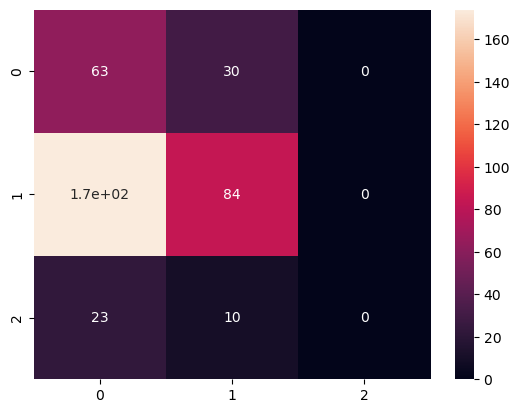

In [ ]:
print("Printable Confusion Matrix from Model 1")
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat1, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall,fscore,support = precision_recall_fscore_support(final_original1,final_prediction1,labels=[0,1,2])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision

array([0.24230769, 0.67741935, 0.        ])

In [ ]:
recall

array([0.67741935, 0.3255814 , 0.        ])

In [ ]:
fscore

array([0.35694051, 0.43979058, 0.        ])

In [ ]:
support

array([ 93, 258,  33])

Printable Confusion Matrix from Model 2


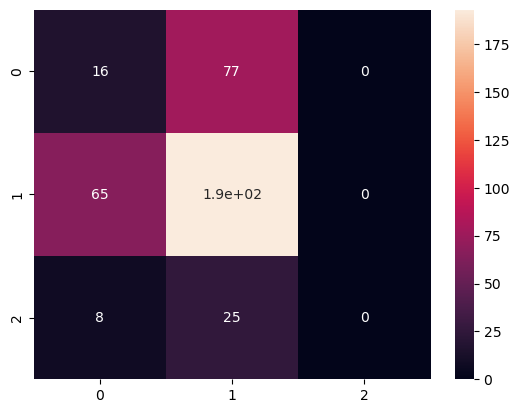

In [ ]:
print("Printable Confusion Matrix from Model 2")
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat2, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original2,final_prediction2,labels=[0,1,2])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision

array([0.17977528, 0.65423729, 0.        ])

In [ ]:
recall

array([0.17204301, 0.74806202, 0.        ])

In [ ]:
fscore

array([0.17582418, 0.69801085, 0.        ])

In [ ]:
support

array([ 93, 258,  33])

Printable Confusion Matrix from Model 3


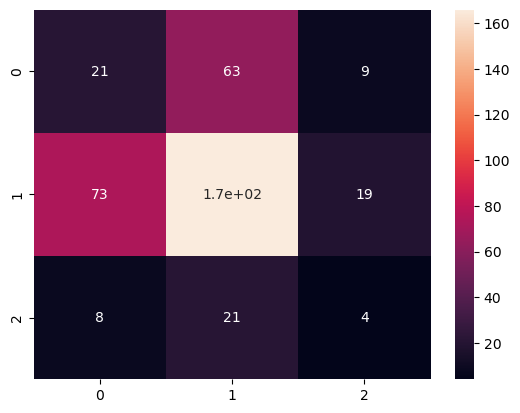

In [ ]:
print("Printable Confusion Matrix from Model 3")
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat3, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original3,final_prediction3,labels=[0,1,2])

In [ ]:
precision

array([0.20588235, 0.664     , 0.125     ])

In [ ]:
recall

array([0.22580645, 0.64341085, 0.12121212])

In [ ]:
fscore

array([0.21538462, 0.65354331, 0.12307692])

In [ ]:
support

array([ 93, 258,  33])

Printable Confusion Matrix from Model 4


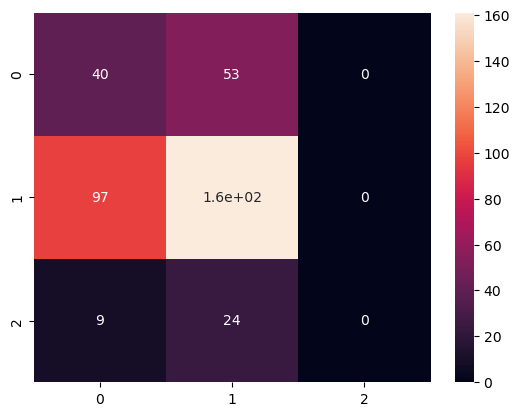

In [ ]:
print("Printable Confusion Matrix from Model 4")
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat4, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original3,final_prediction4,labels=[0,1,2])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision

array([0.2739726 , 0.67647059, 0.        ])

In [ ]:
recall

array([0.43010753, 0.62403101, 0.        ])

In [ ]:
fscore

array([0.33472803, 0.64919355, 0.        ])

In [ ]:
support

array([ 93, 258,  33])

Printable Confusion Matrix from Model 5


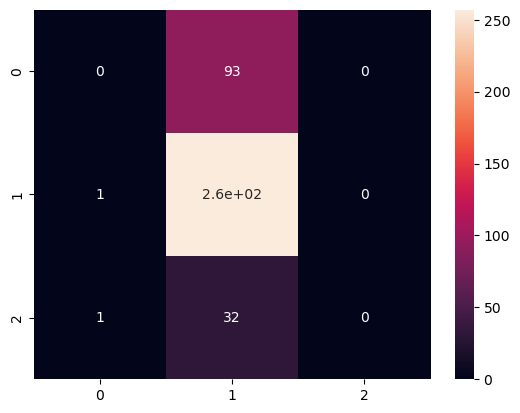

In [ ]:
print("Printable Confusion Matrix from Model 5")
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat5, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original3,final_prediction5,labels=[0,1,2])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision

array([0.        , 0.67277487, 0.        ])

In [ ]:
recall

array([0.        , 0.99612403, 0.        ])

In [ ]:
fscore

array([0.      , 0.803125, 0.      ])

In [ ]:
support

array([ 93, 258,  33])

In [ ]:
# Loop for creating ensemble output
# Loop for creating ensemble output
numCount0 = 0
numCount1 = 0
numCount2 = 0
TruePositiveRate1=[0.67741935, 0.3255814 , 0] 
TruePositiveRate2=[0.17204301, 0.74806202, 0] 
TruePositiveRate3=[0.22580645, 0.64341085, 0.12121212]
TruePositiveRate4=[0.43010753, 0.62403101, 0] 
TruePositiveRate5=[0, 0.99612403, 0]        
#List for ensemble model
final_predictionF = []
final_originalF = []
for i in range(len(final_prediction1)):
    #First model
    l1 = final_prediction1[i]
    l2 = final_original1[i]
    #Second model
    l21 = final_prediction2[i]
    l22 = final_original2[i]
    #Third model
    l31 = final_prediction3[i]
    l32 = final_original3[i]
    #FOURTH model
    l41 = final_prediction4[i]
    l42 = final_original3[i]
    #Fifth model
    l51 = final_prediction5[i]
    l52 = final_original3[i]
    #Ensemble model
    #lF = final_predictionF[i]
    #lF = final_originalF[i]
    # For Model 1
    if (l1==0) or (l1==1) or (l1==2):
        if(l1==0):
            #numCount0=numCount0+TruePositiveRate1[0]+weights[0]*weights[0] #58
            #numCount0=numCount0+TruePositiveRate1[0] #65 (0, 250, 0)
            #numCount0=numCount0+weights[0]*weights[0] #50
            #numCount0=numCount0+weights[0]*2 #29.9
            if ((l21 !=0) and (l31!=0) and (l41!=0) and (l51!=0)):
                #numCount0=numCount0+weights[0]*2
                numCount0=numCount0+TruePositiveRate1[0]+weights[0]*2
            else:
                numCount0=numCount0+TruePositiveRate1[0]+weights[0]
            
        if(l1==1):
            #numCount1=numCount1+TruePositiveRate1[1]+weights[1]
            #numCount1=numCount1+TruePositiveRate1[1]
            #numCount1=numCount1+weights[1]
            if ((l21 !=1) and (l31!=1) and (l41!=1) and (l51!=1)):
                #numCount1=numCount1+TruePositiveRate1[1]+weights[1]
                #numCount1=numCount1+weights[1]*1
                numCount1=numCount1+TruePositiveRate1[1]+weights[1]*1
            else:
                numCount1=numCount1+TruePositiveRate1[1]+weights[1]
        if(l1==2):
            #numCount2=numCount2+TruePositiveRate1[2]+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+TruePositiveRate1[2]
            #numCount2=numCount2+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+weights[2]*3
            if ((l21 !=2) and (l31!=2) and (l41!=2) and (l51!=2)):
                #numCount2=numCount2+weights[2]*3
                numCount2=numCount2+TruePositiveRate1[2]+weights[2]*3
            else:
                numCount2=numCount2+TruePositiveRate1[2]+weights[2]

    # For Model 2    
    if (l21==0) or (l21==1) or (l21==2):
        if(l21==0):
            #numCount0=numCount0+TruePositiveRate2[0]+weights[0]*weights[0]
            #numCount0=numCount0+TruePositiveRate2[0]
            #numCount0=numCount0+weights[0]*weights[0]
            #numCount0=numCount0+weights[0]*2
            if ((l1 !=0) and (l31!=0) and (l41!=0) and (l51!=0)):
                #numCount0=numCount0+weights[0]*2
                numCount0=numCount0+TruePositiveRate2[0]+weights[0]*2
            else:
                numCount0=numCount0+TruePositiveRate2[0]+weights[0]
        if(l21==1):
            #numCount1=numCount1+TruePositiveRate2[1]+weights[1]
            #numCount1=numCount1+TruePositiveRate2[1]
            #numCount1=numCount1+weights[1]
            if ((l1 !=1) and (l31!=1) and (l41!=1) and (l51!=1)):
                #numCount1=numCount1+weights[1]*1
                numCount1=numCount1+TruePositiveRate2[1]+weights[1]*1
            else:
                numCount1=numCount1+TruePositiveRate2[1]+weights[1]
        if(l21==2):
            #numCount2=numCount2+TruePositiveRate2[2]+weights[2]*weights[2]*weights[2]    
            #numCount2=numCount2+TruePositiveRate2[2]   
            #numCount2=numCount2+weights[2]*weights[2]*weights[2]    
            #numCount2=numCount2+weights[2]*3
            if ((l1 !=2) and (l31!=2) and (l41!=2) and (l51!=2)):
                #numCount2=numCount2+weights[2]*3
                numCount2=numCount2+TruePositiveRate2[2]+weights[2]*3
            else:
                numCount2=numCount2+TruePositiveRate2[2]+weights[2]

    # For Model 3
    if (l31==0) or (l31==1) or (l31==2):
        if(l31==0):
            #numCount0=numCount0+TruePositiveRate3[0]+weights[0]*weights[0]
            #numCount0=numCount0+TruePositiveRate3[0]
            #numCount0=numCount0+weights[0]*weights[0]
            #numCount0=numCount0+weights[0]*2
            if ((l1 !=0) and (l21!=0) and (l41!=0) and (l51!=0)):
                #numCount0=numCount0+weights[0]*2
                numCount0=numCount0+TruePositiveRate3[0]+weights[0]*2
            else:
                numCount0=numCount0+TruePositiveRate3[0]+weights[0]
        if(l31==1):
            #numCount1=numCount1+TruePositiveRate3[1]+weights[1]
            #numCount1=numCount1+TruePositiveRate3[1]
            #numCount1=numCount1+weights[1]
            if ((l1 !=1) and (l21!=1) and (l41!=1) and (l51!=1)):
                #numCount1=numCount1+weights[1]*1
                numCount1=numCount1+TruePositiveRate3[1]+weights[1]*1
            else:
                numCount1=numCount1+TruePositiveRate3[1]+weights[1]
        if(l31==2):
            #numCount2=numCount2+TruePositiveRate3[2]+weights[2]*weights[2]*weights[2]    
            #numCount2=numCount2+TruePositiveRate3[2]    
            #numCount2=numCount2+weights[2]*weights[2]*weights[2]    
            #numCount2=numCount2+weights[2]*3
            if ((l1 !=2) and (l21!=2) and (l41!=2) and (l51!=2)):
                #numCount2=numCount2+weights[2]*3
                numCount2=numCount2+TruePositiveRate3[2]+weights[2]*3
            else:
                numCount2=numCount2+TruePositiveRate3[2]+weights[2]
    # For Model 4
    if (l41==0) or (l41==1) or (l41==2):
        if(l41==0):
            #numCount0=numCount0+TruePositiveRate4[0]+weights[0]*weights[0]
            #numCount0=numCount0+TruePositiveRate4[0]
            #numCount0=numCount0+weights[0]*weights[0]
            #numCount0=numCount0+weights[0]*2
            if ((l1 !=0) and (l21!=0) and (l31!=0) and (l51!=0)):
                #numCount0=numCount0+weights[0]*2
                numCount0=numCount0+TruePositiveRate4[0]+weights[0]*2
            else:
                numCount0=numCount0+TruePositiveRate4[0]+weights[0]
        if(l41==1):
            #numCount1=numCount1+TruePositiveRate4[1]+weights[1]
            #numCount1=numCount1+TruePositiveRate4[1]
            #numCount1=numCount1+weights[1]
            if ((l1 !=1) and (l21!=1) and (l31!=1) and (l51!=1)):
                #numCount1=numCount1+weights[1]*1
                numCount1=numCount1+TruePositiveRate4[1]+weights[1]*1
            else:
                numCount1=numCount1+TruePositiveRate4[1]+weights[1]
        if(l41==2):
            #numCount2=numCount2+TruePositiveRate4[2]+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+TruePositiveRate4[2]
            #numCount2=numCount2+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+weights[2]*3
            if ((l1 !=2) and (l21!=2) and (l31!=2) and (l51!=2)):
                #numCount2=numCount2+weights[2]*3
                numCount2=numCount2+TruePositiveRate4[2]+weights[2]*3
            else:
                numCount2=numCount2+TruePositiveRate4[2]+weights[2]
    # For Model 5
    if (l51==0) or (l51==1) or (l51==2):
        if(l51==0):
            #numCount0=numCount0+TruePositiveRate5[0]+weights[0]*weights[0]
            #numCount0=numCount0+weights[0]*weights[0]
            #numCount0=numCount0+TruePositiveRate5[0]
            #numCount0=numCount0+weights[0]*2
            if ((l1 !=0) and (l21!=0) and (l31!=0) and (l41!=0)):
                #numCount0=numCount0+weights[0]*2
                numCount0=numCount0+TruePositiveRate5[0]+weights[0]*2
            else:
                numCount0=numCount0+TruePositiveRate5[0]+weights[0]
        if(l51==1):
            #numCount1=numCount1+TruePositiveRate5[1]+weights[1]
            #numCount1=numCount1+TruePositiveRate5[1]
            #numCount1=numCount1+weights[1]
            if ((l1 !=1) and (l21!=1) and (l31!=1) and (l41!=1)):
                #numCount1=numCount1+weights[1]*1
                numCount1=numCount1+TruePositiveRate5[1]+weights[1]*1
            else:
                numCount1=numCount1+TruePositiveRate5[1]+weights[1]
        if(l51==2):
            #numCount2=numCount2+TruePositiveRate5[2]+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+TruePositiveRate5[2]
            #numCount2=numCount2+weights[2]*weights[2]*weights[2]
            #numCount2=numCount2+weights[2]*3
            if ((l1 !=2) and (l21!=2) and (l31!=2) and (l41!=2)):
                #numCount2=numCount2+weights[2]*3
                numCount2=numCount2+TruePositiveRate5[2]+weights[2]*3
            else:
                numCount2=numCount2+TruePositiveRate5[2]+weights[2]
    if ((numCount0 > numCount1) and (numCount0 > numCount2)):
        final_predictionF.append(0)
    if ((numCount1 > numCount2) and (numCount1 > numCount0)):
        final_predictionF.append(1)
    if ((numCount2 > numCount1) and (numCount2 > numCount0)):
        final_predictionF.append(2)
    # SET To Default all the counters
    
    #print("numCount0->",numCount0)
    #print("numCount1->",numCount1)
    #print("numCount2->",numCount2)

    numCount0 = 0
    numCount1 = 0
    numCount2 = 0
    #j = j+1

In [ ]:
print("***********Confusion Matrix by Ensemble MODEL  over Test Set**********************")
mat6 = sklearn.metrics.confusion_matrix(final_original3,final_predictionF)
mat6

***********Confusion Matrix by Ensemble MODEL  over Test Set**********************


array([[ 16,  76,   1],
       [ 49, 203,   6],
       [  6,  26,   1]])

In [ ]:
sklearn.metrics.accuracy_score(final_original3,final_predictionF)

0.5729166666666666

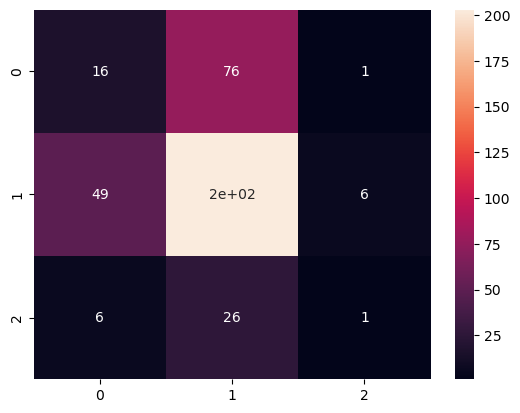

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cm4 = pd.DataFrame(mat6, range(3), range(3))

sns.heatmap(df_cm4, annot=True) 
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original3,final_predictionF,labels=[0,1,2])

In [ ]:
precision

array([0.22535211, 0.66557377, 0.125     ])

In [ ]:
recall

array([0.17204301, 0.78682171, 0.03030303])

In [ ]:
fscore

array([0.19512195, 0.72113677, 0.04878049])

In [ ]:
support

array([ 93, 258,  33])